## Baseline Approach

In order to make a good comparison between training with pretext weights vs random weights, we should use a strong baseline that's known to give good performance.

This approach is taken from: [train_imagenette.py](https://github.com/fastai/fastai2/blob/3faec089e511ee68330dfdc182add8c863df3ecd/nbs/examples/train_imagenette.py)

As of January 2020 the [best parameters](https://github.com/fastai/imagenette/blob/58a63175a2c6457650289d32741940d6a7d58fbf/2020-01-train.md) are:

```
--lr 8e-3 
--sqrmom 0.99 
--mom 0.95 
--eps 1e-6 
--bs 64 
--opt ranger 
--sa 1
--fp16 1 
--arch xse_resnext50 
--pool MaxPool
```


In order to save time we're going to use 128x128 images and 5 epochs. This means we should expect an accuracy of ~84.71%.

In [1]:
import torch

from functools import partial
from fastprogress import fastprogress

from fastai2.layers import MishJit, MaxPool, LabelSmoothingCrossEntropy
from fastai2.basics import URLs, untar_data
from fastai2.learner import Learner
from fastai2.metrics import accuracy, top_k_accuracy
from fastai2.optimizer import ranger
from fastai2.vision.data import ImageBlock
from fastai2.vision.augment import RandomResizedCrop, FlipItem, RandomErasingsing
from fastai2.vision.models.xresnet import xse_resnext50
from fastai2.torch_core import num_distrib
from fastai2.callback.schedule import fit_flat_cos


from fastai2.data.block import DataBlock, CategoryBlock
from fastai2.data.transforms import (GrandparentSplitter, get_image_files,
                                     parent_label)

from fastcore.utils import num_cpus


/home/josh/anaconda3/envs/fastai2/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/josh/anaconda3/envs/fastai2/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/josh/anaconda3/envs/fastai2/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/josh/anaconda3/envs/fastai2/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
# If you use identically sized images for all inputs and your 
# network does not dynamically change, 
# this will typically lead to a faster runtime
torch.backends.cudnn.benchmark = True

fastprogress.MAX_COLS = 80

In [3]:
# Default parameters
gpu=None
woof=0
lr=1e-2
size=128
sqrmom=0.99
mom=0.9
eps=1e-6
epochs=5
bs=64
mixup=0.
opt='ranger',
arch='xresnet50'
sh=0.
sa=0
sym=0
beta=0.
act_fn='MishJit'
fp16=0
pool='AvgPool',
dump=0
runs=1
meta=''

In [4]:
# Chosen parameters
lr=8e-3
sqrmom=0.99
mom=0.95
eps=1e-6
bs=64 
opt='ranger'
sa=1
fp16=0               #NOTE: My GPU cannot run fp16 :'(
arch='xse_resnext50' 
pool='MaxPool'

gpu=0

# NOTE: Normally loaded from their corresponding string
m = xse_resnext50
act_fn = MishJit
pool = MaxPool

runs = 3

In [5]:
if gpu is not None: torch.cuda.set_device(gpu)
if   opt=='adam'  : opt_func = partial(Adam, mom=mom, sqr_mom=sqrmom, eps=eps)
elif opt=='rms'   : opt_func = partial(RMSprop, sqr_mom=sqrmom)
elif opt=='sgd'   : opt_func = partial(SGD, mom=mom)
elif opt=='ranger': opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

In [6]:
def get_dbunch(size, woof, bs, sh=0., workers=None):
    if size<=224: path = URLs.IMAGEWOOF_320 if woof else URLs.IMAGENETTE_320
    else        : path = URLs.IMAGEWOOF     if woof else URLs.IMAGENETTE
    path = URLs.IMAGEWANG_160
    source = untar_data(path)
    if workers is None: workers = min(8, num_cpus())
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       splitter=GrandparentSplitter(valid_name='val'),
                       get_items=get_image_files, get_y=parent_label)
    item_tfms=[RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    batch_tfms=RandomErasing(p=0.9, max_count=3, sh=sh) if sh else None
    return dblock.databunch(source, path=source, bs=bs, num_workers=workers,
                            item_tfms=item_tfms, batch_tfms=batch_tfms)

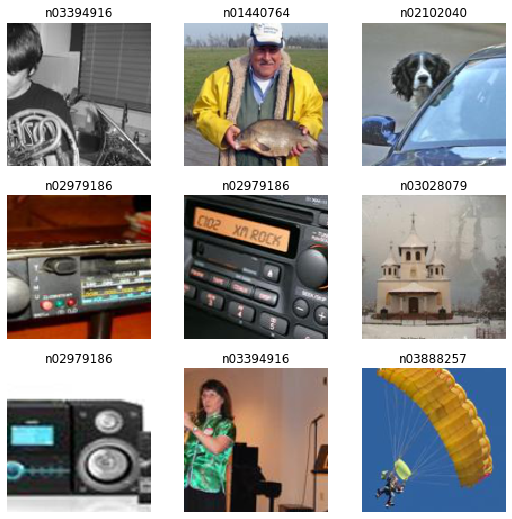

In [9]:
dbunch.show_batch()

In [8]:
dbunch = get_dbunch(size, woof, bs, sh=sh)
if not gpu: print(f'lr: {lr}; size: {size}; sqrmom: {sqrmom}; mom: {mom}; eps: {eps}')

lr: 0.008; size: 128; sqrmom: 0.99; mom: 0.95; eps: 1e-06


In [ ]:
for run in range(runs):
        print(f'Run: {run}')
        learn = Learner(dbunch, m(c_out=20, act_cls=act_fn, sa=sa, sym=sym, pool=pool), opt_func=opt_func, \
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
        if dump: print(learn.model); exit()
        if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
        #n_gpu = torch.cuda.device_count()
        #if gpu is None and n_gpu: learn.to_parallel()
        if num_distrib()>1: learn.to_distributed(gpu) # Requires `-m fastai.launch`
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

This gives us an average of **84.3227%** which is slightly lower than what we expected (**84.71%**).

One change I made was to turn off fp16 because it's not supported on my GPU. Maybe this had an effect?